1. Data loading and cleaning
2. Object Segmentation
    1. U-Net
    2. YOLO seg

In [35]:
# Download the data from Kaggle and unzip it

import kaggle
kaggle.api.authenticate()

kaggle.api.dataset_download_files('humansintheloop/teeth-segmentation-on-dental-x-ray-images', path='data', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/humansintheloop/teeth-segmentation-on-dental-x-ray-images


In [36]:
import os
import shutil

import json

def create_directories(base_dir):

    os.makedirs(os.path.join(base_dir,'images'), exist_ok=True)         # Images dir
    os.makedirs(os.path.join(base_dir,'labels'), exist_ok=True)         # Labels dir

    subdirs = [
    "images/train", 
    "images/test", 
    "images/valid",
    "labels/train", 
    "labels/test", 
    "labels/valid"]

    # Create directories
    for subdir in subdirs:
        os.makedirs(os.path.join(base_dir, subdir), exist_ok=True)
        
def convert_annotation(label_file, image_w, image_h):
    
    with open(label_file, "r") as f:
        data = json.load(f)

    new_label_file = label_file.replace('.jpg.json', '.txt')

    with open(new_label_file, 'w') as f:

        for obj in data['objects']:

            tooth = obj['classTitle']           # Tooth label
            points = obj['points']['exterior']  # Polygon points
            yolo_seg = []
 
            for x, y in points:
                norm_x = x / image_w
                norm_y = y / image_h
                yolo_seg.append(f"{norm_x:.6f} {norm_y:.6f}")  # Format to 6 decimal places

            # Write the class and normalized polygon points to the file
            f.write(f"{tooth} " + " ".join(yolo_seg) + '\n')


In [37]:
# Create a dataset complient to YOLO format
import os 
from sklearn.model_selection import train_test_split
from PIL import Image

base_dir = 'data/teeth_segmentation'

train_data, temp_data = train_test_split(os.listdir('data/Teeth Segmentation PNG/d2/img'), test_size=0.2, random_state=42)
test_data, valid_data = train_test_split(temp_data, test_size=0.5, random_state=42)

train_data = [os.path.join('data/Teeth Segmentation PNG/d2/img', image) for image in train_data]
test_data = [os.path.join('data/Teeth Segmentation PNG/d2/img', image) for image in test_data]
valid_data = [os.path.join('data/Teeth Segmentation PNG/d2/img', image) for image in valid_data]

print(f'Train test split created')
print(f'Train data: {len(train_data)}')
print(f'Test data: {len(test_data)}')
print(f'Valid data: {len(valid_data)}')

create_directories(base_dir)

print(f'Directories created')

for el in train_data:

    img = Image.open(el)
    convert_annotation(el.replace('img', 'ann')+'.json', img.size[0], img.size[1])

    shutil.move(el, os.path.join(base_dir, 'images/train'))
    shutil.move(el.replace('img', 'ann').replace('.jpg', '.txt'), os.path.join(base_dir, 'labels/train'))

print(f'Train data converted')

for el in test_data:

    img = Image.open(el)    
    convert_annotation(el.replace('img','ann')+'.json', img.size[0], img.size[1])

    shutil.move(el, os.path.join(base_dir, 'images/test'))
    shutil.move(el.replace('img', 'ann').replace('.jpg', '.txt'), os.path.join(base_dir, 'labels/test'))

print(f'Test data converted')

for el in valid_data:
    
    img = Image.open(el)    
    convert_annotation(el.replace('img', 'ann')+'.json', img.size[0], img.size[1])

    shutil.move(el, os.path.join(base_dir, 'images/valid'))
    shutil.move(el.replace('img', 'ann').replace('.jpg', '.txt'), os.path.join(base_dir, 'labels/valid'))

print(f'Valid data converted')

Train test split created
Train data: 478
Test data: 60
Valid data: 60
Directories created
Train data converted
Test data converted
Valid data converted


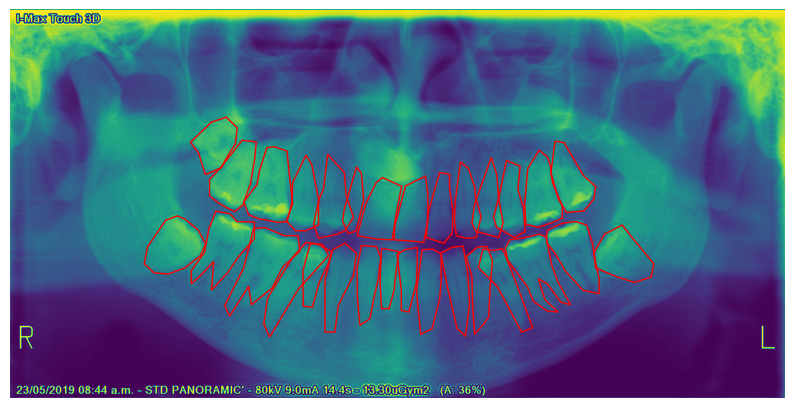

In [6]:
# PLot a sample image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

image = Image.open('data/teeth_segmentation/images/train/134.jpg')

labels = []
for line in open('data/teeth_segmentation/labels/train/134.txt', 'r').readlines():
    if line:
        labels.append([float(el) for el in line.strip().split()])


fig = plt.figure(figsize=(10, 10))
plt.imshow(image)#[0], cmap="gray")
plt.axis('off')

for seg_mask in labels:

    tooth = seg_mask[0]
    points = seg_mask[1:]

    x = np.array(points[::2])*image.size[0]
    y = np.array(points[1::2])*image.size[1]

    plt.fill(x, y, edgecolor='r', fill=False)

plt.show()

### U-NET

In [69]:
# Create the dataset
from torch.utils.data import Dataset
import numpy as np
import cv2

class TeethDataset(Dataset):
    
    def __init__(self, base_dir, task, transform=None, mask_transform=None):
        
        self.base_dir = base_dir
        self.transform = transform
        self.mask_transform = mask_transform

        self.images_dir = os.path.join(base_dir, 'images', task)
        self.labels_dir = os.path.join(base_dir, 'labels', task)

        self.images = os.listdir(self.images_dir)

    def __len__(self):
        return len(self.images)
    
    
    def point_to_mask(self, label_path, image_size):
        mask = np.zeros((image_size[0], image_size[1]), dtype=np.uint8)  # Black background

        for points in open(label_path, 'r').readlines():
            if points:
                points = [float(el) for el in points.strip().split()[1:]]
                points = np.array(points).reshape(-1, 2)  # Reshape list into (N,2) array
            
                points[:, 1] *= image_size[0]  # Scale x-coordinates
                points[:, 0] *= image_size[1]  # Scale y-coordinates

                points = points.astype(np.int32)  # Convert to integer pixel values
            
                cv2.fillPoly(mask, [points], 255)
        
        return mask


    def __getitem__(self, idx):

        img_path = os.path.join(self.images_dir, self.images[idx])
        label_path = os.path.join(self.labels_dir, self.images[idx].replace('.jpg', '.txt'))

        image = Image.open(img_path).convert('RGB')
        
        mask = self.point_to_mask(label_path, image.size)
        mask_img = Image.fromarray(mask)

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask_img = self.mask_transform(mask_img)

        return image, mask_img    
    

Image shape: torch.Size([3, 416, 416])
Mask shape: torch.Size([1, 416, 416])


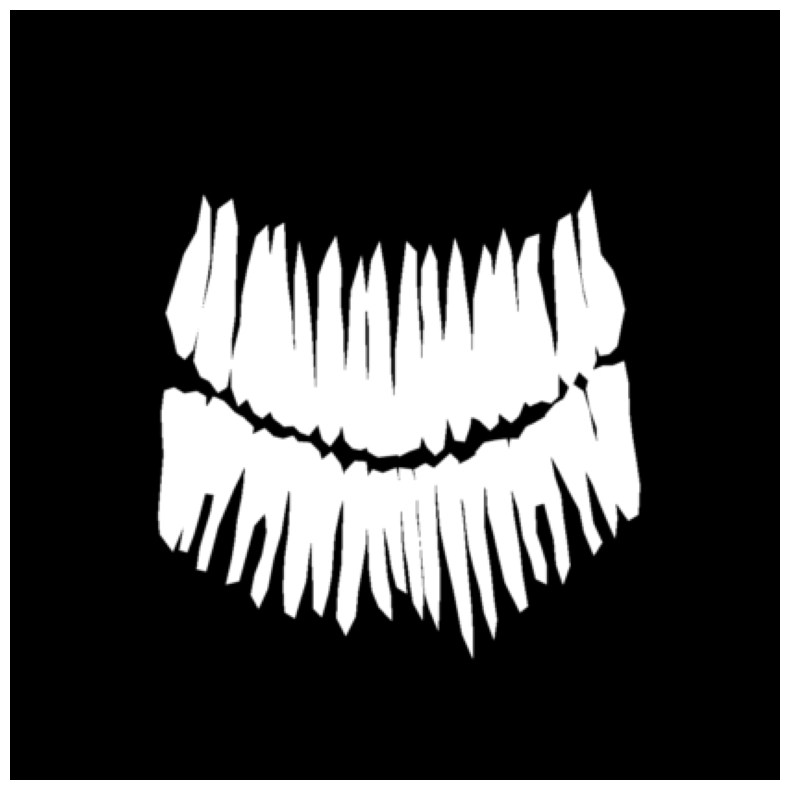

In [70]:
# Create the datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np

transform = transforms.Compose([
    transforms.Resize((416, 416)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mask_transform = transforms.Compose([
    transforms.Resize((416, 416)),   
    transforms.ToTensor()            
])

base_dir = 'data/teeth_segmentation'

train_dataset = TeethDataset(base_dir, 'train', transform=transform, mask_transform=mask_transform)
test_dataset = TeethDataset(base_dir, 'test', transform=transform, mask_transform=mask_transform)
valid_dataset = TeethDataset(base_dir, 'valid',transform=transform, mask_transform=mask_transform)


# PLot a sample image with the 
image, mask = train_dataset[0]

print(f'Image shape: {image.shape}')
print(f'Mask shape: {mask.shape}')

fig = plt.figure(figsize=(10, 10))
plt.imshow(mask[0], cmap="gray")
plt.axis('off')
plt.show()



In [71]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder
        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 416 --> 208

        self.encoder2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 208 --> 104

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)  # 104 --> 208
        self.decoder1 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.upconv2 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)  # 208 --> 416
        self.decoder2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=1)  # Final output layer
        )

    def forward(self, x):
        # Encoding
        x1 = self.encoder1(x)
        x2 = self.pool1(x1)

        x3 = self.encoder2(x2)
        x4 = self.pool2(x3)

        # Bottleneck
        x5 = self.bottleneck(x4)

        # Decoding
        x6 = self.upconv1(x5)  # 104 → 208
        x7 = self.decoder1(x6)

        x8 = self.upconv2(x7)  # 208 → 416
        x9 = self.decoder2(x8)

        return x9


In [85]:
# IMplement IuO to compute the goodness of the model prediction

def IoU(pred, target):

    pred = torch.sigmoid(pred)  # Convert logits to probabilities

    # Convert to binary masks using threshold
    pred = (pred > 0.5).float()
    target = target.float()  # Ensure target is also float

    # Flatten tensors
    pred = pred.view(-1)
    target = target.view(-1)

    # Compute intersection and union
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection

    # Compute IoU (avoid division by zero)
    iou = intersection / (union + 1e-6)

    return iou.item() 

In [90]:
import torch.nn as nn
import torch

class DiceBCELoss(nn.Module):
    def __init__(self):
        super(DiceBCELoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()  # Use BCE with logits for numerical stability

    def forward(self, predictions, targets):

        print(f'Predictions shape: {predictions.shape}')
        print(f'Targets shape: {targets.shape}')

        pred_class = predictions[:, 0]  # Class predictions 
        pred_mask = predictions[:, 1:]  # Segmentation masks 

        target_class = targets[:, 0]  # Class ground truth
        target_mask = targets[:, 1:]  # Segmentation ground truth

        bce_loss = self.bce_loss(pred_class, target_class) + self.bce_loss(pred_mask, target_mask)

        smooth = 1e-6  # Small constant for numerical stability
        intersection = (pred_mask * target_mask).sum(dim=(2, 3))  # Sum over spatial dimensions
        union = pred_mask.sum(dim=(2, 3)) + target_mask.sum(dim=(2, 3))

        dice_loss = 1 - (2 * intersection + smooth) / (union + smooth)
        dice_loss = dice_loss.mean()

        return bce_loss + dice_loss

In [91]:
# Implement the fit loop

def train_fn(model, train_loader, optimizer, criterion, device, phase):
    
    if phase == 'train':
        model.train()
    else:
        model.eval()

    running_loss = 0.0
    running_IoU = 0.0
    
    for images, labels in train_loader:
        
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(phase == 'train'):  
            outputs = model(images)
            loss = criterion(outputs, labels)
        
            if phase == 'train':
                loss.backward()
                optimizer.step()
        
        running_loss += loss.item()
        running_IoU += IoU(outputs, labels)

        del images, labels, outputs, loss
        torch.cuda.empty_cache()  # Clears unused memory
        torch.cuda.synchronize()  # Ensures memory is freed properly

    return running_loss / len(train_loader), running_IoU / len(train_loader)

In [92]:
# Implement the main training loop

import torch

device = 'cuda:0'
batch_size = 8
num_workers = 3
lr = 1e-4
num_epochs = 40

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

model = UNet().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#criterion = DiceBCELoss()
criterion = nn.BCEWithLogitsLoss()

loss_train = []
loss_test = []

acc_train = []
acc_test = []

for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1}/{num_epochs} \n')
    
    train_loss, train_acc = train_fn(model, train_loader, optimizer, criterion, device, 'train')
    print(f"Train Loss: {train_loss:.3f},  Train IoU: {train_acc:.3f}")

    test_loss, test_acc = train_fn(model, test_loader, optimizer, criterion, device, 'test')
    print(f"Test Loss: {test_loss:.3f},  Test IoU: {test_acc:.3f}")

    loss_train.append(train_loss)
    loss_test.append(test_loss)

    acc_train.append(train_acc)
    acc_test.append(test_acc)


Dataloaders created, len train: 60, len test: 8, len valid: 15
Epoch: 1/40 



Train Loss: 0.684,  Train IoU: 0.000
Test Loss: 0.679,  Test IoU: 0.000
Epoch: 2/40 

Train Loss: 0.670,  Train IoU: 0.000
Test Loss: 0.637,  Test IoU: 0.000
Epoch: 3/40 

Train Loss: 0.451,  Train IoU: 0.000
Test Loss: 0.383,  Test IoU: 0.000
Epoch: 4/40 

Train Loss: 0.378,  Train IoU: 0.000
Test Loss: 0.380,  Test IoU: 0.000
Epoch: 5/40 

Train Loss: 0.376,  Train IoU: 0.000
Test Loss: 0.379,  Test IoU: 0.000
Epoch: 6/40 

Train Loss: 0.376,  Train IoU: 0.000
Test Loss: 0.378,  Test IoU: 0.000
Epoch: 7/40 

Train Loss: 0.375,  Train IoU: 0.000
Test Loss: 0.377,  Test IoU: 0.000
Epoch: 8/40 

Train Loss: 0.373,  Train IoU: 0.000
Test Loss: 0.375,  Test IoU: 0.000
Epoch: 9/40 

Train Loss: 0.372,  Train IoU: 0.000
Test Loss: 0.374,  Test IoU: 0.000
Epoch: 10/40 

Train Loss: 0.371,  Train IoU: 0.000
Test Loss: 0.372,  Test IoU: 0.000
Epoch: 11/40 

Train Loss: 0.369,  Train IoU: 0.000
Test Loss: 0.371,  Test IoU: 0.000
Epoch: 12/40 

Train Loss: 0.367,  Train IoU: 0.000
Test Loss: 0.3

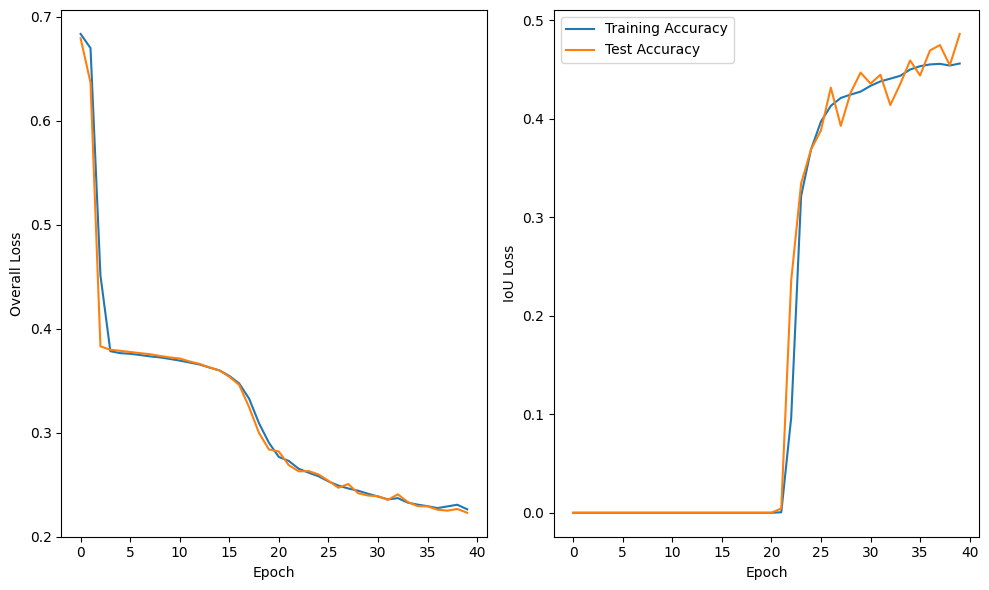

In [93]:

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
axes[0].plot(loss_train, label='Training Loss')
axes[0].plot(loss_test, label='Test Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Overall Loss')

axes[1].plot(acc_train, label='Training Accuracy')
axes[1].plot(acc_test, label='Test Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('IoU Loss')

plt.legend()
plt.tight_layout()
plt.show()

In [98]:
def overlay_prediction(image, mask):
    
    image = image.to('cpu').numpy().transpose(1, 2, 0) 
    mask = mask.to('cpu').numpy()

    image = (image * 255).astype(np.uint8)

    mask = (mask > 0.5).astype(np.uint8) * 255 

    mask_colored = np.zeros_like(image)
    mask_colored[:, :, 2] = mask  # Set only red channel

    overlay = cv2.addWeighted(image, 0.7, mask_colored, 0.3, 0)

    return overlay


In [99]:
import os

image_list = np.random.choice(os.listdir(os.path.join('data/teeth_segmentation', 'images', 'valid')), 6)
image_list = [os.path.join('data/teeth_segmentation', 'images', 'valid', file) for file in image_list]

labels = [file.replace('.jpg', '.txt').replace('images', 'labels') for file in image_list]

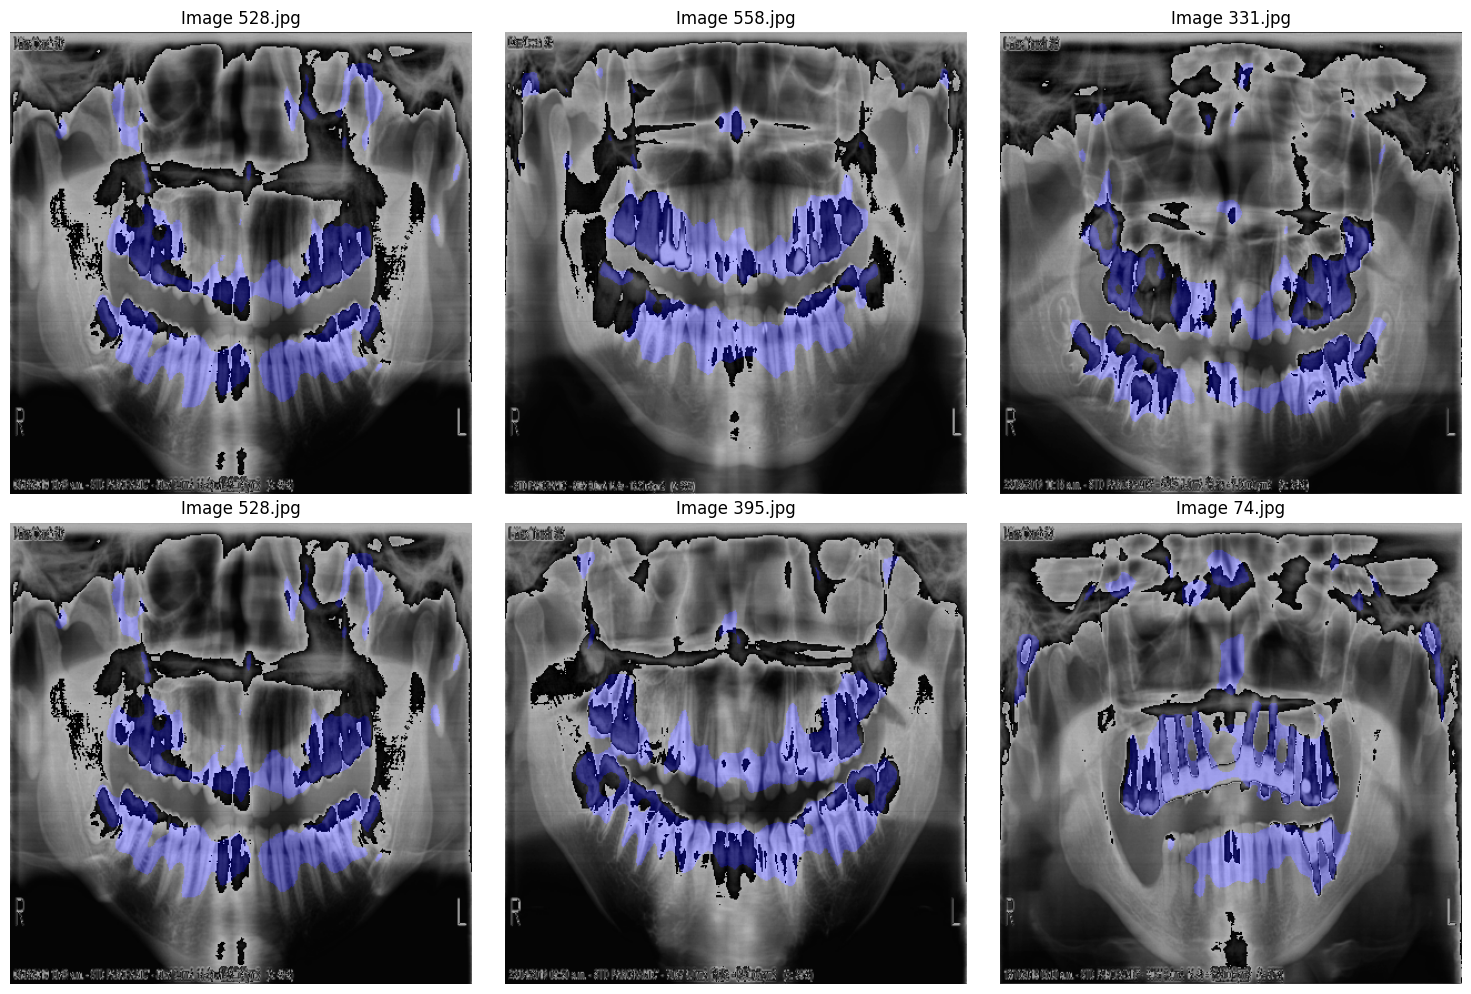

In [97]:
# plot a set of 6 images with predicted bounding boxes and labels
import numpy as np

model.eval()

labels = []
scores = []

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, image_path in enumerate(image_list):
    image = Image.open(image_path).convert('RGB')
    
    image_w, image_h = image.size

    image_tensor = transform(image).unsqueeze(0).to(device)
    
    prediction = model(image_tensor)
    mask = prediction[0, 0].cpu().detach()

    overlay = overlay_prediction(image_tensor.squeeze(0), mask)

    axes[i // 3, i % 3].imshow(overlay)
    axes[i // 3, i % 3].axis('off')
    axes[i // 3, i % 3].set_title(f'Image {image_path.split("/")[-1]}')

plt.tight_layout()  
plt.show()

### YOLO seg

In [ ]:
# import yaml
from pathlib import Path
import yaml

# Define the paths --> maybe not needed
settings_file = Path.home() / "/home/fabiotdt/.config/Ultralytics/settings.yaml" # Path to the Ultralytics setting file
custom_dataset_path = "/home/fabiotdt/Documents/rs_lab/data/teeth_segmentation"  # Path to the fruit_detection dataset
original_dataset_path = "/home/fabiotdt/Documents/datasets"  # Path to the original folder containing the datasets

# Function to update the settings file
def update_ultralytics_path(new_path):
    if settings_file.exists():
        with open(settings_file, "r") as file:
            settings = yaml.safe_load(file)
        settings["datasets_dir"] = new_path
        with open(settings_file, "w") as file:
            yaml.safe_dump(settings, file)
        print(f"Updated dataset directory to: {new_path}")
    else:
        raise FileNotFoundError(f"Settings file not found at {settings_file}")

In [ ]:
from ultralytics import YOLO

model = YOLO("../../weights_models/v8/yolov8n-seg.pt")  # Load the weights of the model

# Train the model on your dataset
model.train(
    data="teeth_segmentation.yaml", # Path to the dataset YAML file
    epochs=30,                   # Number of training epochs
    batch=16,                    # Batch size
    imgsz=640,                   # Image size
    device=0,                    # GPU device (0 = first GPU, 'cpu' for CPU)
    workers=4,                   # Number of DataLoader workers
    save_period=-1,              # Save model every n epochs (-1 = don't save intermediate)
    project="teeth_seg",   # Directory to save results
    name="base",      # Subfolder for the run
)

In [ ]:
# Load the model and perform inference
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO

model_name = 'fruit_det/base/weights/best.pt'
fruit_det = YOLO(model_name)

# Perform inference on a subset of the validation dataset
val_images = np.random.choice(os.listdir(os.path.join('fruit_detection', 'images', 'test')), 6)
val_images = [os.path.join('fruit_detection', 'images', 'test', file) for file in val_images]


class_names = ['Apple', 'Banana', 'Orange']

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i, image_path in enumerate(val_images):

    image = Image.open(image_path).convert('RGB')

    axs[i // 3, i % 3].imshow(image)
    axs[i // 3, i % 3].axis('off')
    axs[i // 3, i % 3].set_title(image_path.split('/')[-1])

    image_w, image_h = image.size

    prediction = fruit_det.predict(image)

    for pred in prediction[0].boxes.data.cpu().numpy():

        bbox, conf, lab = pred[:4], pred[4], pred[5]

        x_min, y_min, x_max, y_max = bbox
        
        x = x_min
        y = y_min
        w = (x_max - x_min)
        h = (y_max - y_min)

        rect = plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2) # Plot the bbox
        axs[i // 3, i % 3].add_patch(rect)

        label = class_names[int(lab)]                       # Display the class
        axs[i// 3, i % 3].text(
            x + w, y, label, color='red', fontsize=10,
            bbox=dict(facecolor='white', edgecolor='red', alpha=0.7))

        axs[i// 3, i % 3].text(                             # Display the confidence
            x, y, f'{conf:.2f}', color='red', fontsize=10,
            bbox=dict(facecolor='white', edgecolor='red', alpha=0.7))
